In [89]:
#!pip install matplotlib

In [125]:
import pandas as pd
import matplotlib as plt
import re

df = pd.read_excel('data/data_unpacked.xlsx')

# 2. Data Understanding

## 2.2 Describe data

### Get some samples

In [126]:
df.sample(5)

,url,title,creator,created,artist,category,dimension
8081,https://lh3.googleusercontent.com/ci/ACqFvF23k...,The Other Side,Prateep Kochabua,1997,NaN,TEAL,90cm x 120cm
8584,https://lh3.googleusercontent.com/YN3-xLEWE7PE...,Cattle near a River,NaN,NaN,NaN,WHITE,w740 x h591 cm
3977,https://lh3.googleusercontent.com/ci/ACqFvF0to...,Vendredi Saint en Castille (Good Friday in Ca...,Darío de Regoyos,NaN,NaN,GREEN,NaN
4757,https://lh3.googleusercontent.com/ci/ACqFvF2ka...,Landscape,Piotr Potworowski (1898-1962),1960,NaN,GREEN,NaN
7622,https://lh3.googleusercontent.com/ci/ACqFvF3o9...,It melts,José María Madrid Sanz,2017/2017,NaN,TEAL,100 x 81


### Check shape and columns

In [127]:
print('shape', df.shape,'\n')
print('columns', df.columns.to_list(),'\n')

shape (10282, 7) 

columns ['url', 'title', 'creator', 'created', 'artist', 'category', 'dimension'] 



## 2.3 Explore data 

<AxesSubplot:>

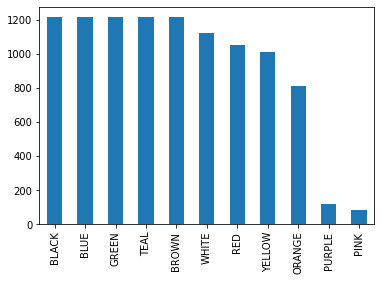

In [128]:
df['category'].value_counts().plot(kind='bar')

### 2.4 Verify data quality

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10282 entries, 0 to 10281
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        10282 non-null  object
 1   title      10282 non-null  object
 2   creator    8923 non-null   object
 3   created    8075 non-null   object
 4   artist     487 non-null    object
 5   category   10282 non-null  object
 6   dimension  8443 non-null   object
dtypes: object(7)
memory usage: 562.4+ KB


# 3. Data Preparation

## 3.1 Data Selection

In [153]:
#Merge creator and artist features into one
def join_creator_artist(row):
    if(not pd.isna(row['creator'])):
        return row['creator']
    if(not pd.isna(row['artist'])):
        return row['artist']
    return None

df2 = df.sample(n=10, random_state=1)
df2['new']=df.apply(join_creator_artist, axis=1)
df2

,url,title,creator,created,artist,category,dimension,new
3720,https://lh3.googleusercontent.com/LTQF4jBsD0uN...,Olive Orchard,Vincent van Gogh,1889,NaN,GREEN,w920.75 x h730.25 in (unframed),Vincent van Gogh
7991,https://lh3.googleusercontent.com/ci/ACqFvF3ZV...,Hillside Cottage,George W. Sotter,NaN,NaN,TEAL,"w26 x h22 inches, w26 x h22 inches",George W. Sotter
6678,https://lh3.googleusercontent.com/ci/ACqFvF0zl...,Untitled (The award winners),Reinhold Rossig,ca. 1955,NaN,RED,120.0 x 100.0 cm,Reinhold Rossig
9053,https://lh3.googleusercontent.com/ci/ACqFvF2xa...,Whale Oil Lamp,NaN,1825–45,NaN,WHITE,h. 3 7/8 in. (9.8 cm),None
9697,https://lh3.googleusercontent.com/ipEqpDDcTQEd...,Bolivia and Western Amazzonia,NaN,1565/1575,NaN,YELLOW,w73 x h117 cm (complete),None
5103,https://lh3.googleusercontent.com/7Um6FLk2JloP...,K.O'd by Griffo,Robert DICKERSON,1953,NaN,ORANGE,w1395 x h1228 cm,Robert DICKERSON
2182,https://lh3.googleusercontent.com/ci/ACqFvF3Jc...,Honor the Parents of the House First,Svay Ken,NaN,NaN,BLUE,w60 x h50 cm,Svay Ken
10144,https://lh3.googleusercontent.com/ci/ACqFvF3cX...,Composition with Bust,NaN,NaN,NaN,YELLOW,w82 x h48 cm,None
2617,https://lh3.googleusercontent.com/ci/ACqFvF1j5...,Group of Three Girls,Amrita Sher-Gil,1935,NaN,BROWN,"oil on canvas, 73.5cm x 99.5cm",Amrita Sher-Gil
6643,https://lh3.googleusercontent.com/ci/ACqFvF1ij...,Nemesis,Cyril Coetzee,1983,NaN,RED,983 mm x 608mm,Cyril Coetzee


## 3.2 Data Cleaning

In [170]:
def normalize_dimension(row):
    if(type(row['dimension'])!=str):
        return None
    try:
        is_contain_size = any([dim in row['dimension'] for dim in ['w','h']])
        is_contain_dim = any([unit in row['dimension'] for unit in ['cm','mm','in']])
        if(is_contain_size):
            #Get numbers to right of w letter
            ## REGEX
            #    (?<=w) Positive lookbehind of w
            #    (    Open group
            #        \d+ digits 
            #        \d+.\d+ decimal digits e.g (1.5-78,9-88.8)
            #    )    Close group
            row['width']= re.search("(?<=w)(\d+.\d+|\d+)", row['dimension']).group(0)
            row['height']= re.search("(?<=h)(\d+.\d+|\d+)", row['dimension']).group(0)            
        else:    
            numbers = re.findall("(\d+.\d+|\d+)", row['dimension'])
            row['width']= numbers[0]
            row['height']=numbers[1]
            
        if is_contain_dim:
            row['unit'] = re.search("(cm|mm|in)", row['dimension']).group(0)
        else:
            row['unit']= 'cm'
            
        return row
    except:
        row['width']="Error"
        row['height']="Error"
        return row
#Copy of df
df3 = df2.copy()

#Standarizing lowercasing
df3['dimension'] = df3['dimension'].str.lower()

#Convert all (,) decimal separator into (.)
df3['dimension'] = df3['dimension'].str.replace(r',', '.', regex=True)

#Convert inches string into abbreviation (in)
df3['dimension'] = df3['dimension'].str.replace(r'inches', 'in', regex=True)


## Remove
##   - character
##   x character
##   fraction numbers (e.g 4/5 5/8 9/9) -> \d\/\d
##   parentheses containing only letters -> \(\D+\)
df3['dimension'] = df3['dimension'].str.replace(r'(-|x|\d\/\d|\(\D+\))', '', regex=True)
df3=df3.apply(normalize_dimension, axis=1)
df3


#df3[~pd.isna(df3['dimension'])]

,url,title,creator,created,artist,category,dimension,new,width,height,unit
3720,https://lh3.googleusercontent.com/LTQF4jBsD0uN...,Olive Orchard,Vincent van Gogh,1889,NaN,GREEN,w920.75 h730.25 in,Vincent van Gogh,920.75,730.25,in
7991,https://lh3.googleusercontent.com/ci/ACqFvF3ZV...,Hillside Cottage,George W. Sotter,NaN,NaN,TEAL,w26 h22 in. w26 h22 in,George W. Sotter,26,22,in
6678,https://lh3.googleusercontent.com/ci/ACqFvF0zl...,Untitled (The award winners),Reinhold Rossig,ca. 1955,NaN,RED,120.0 100.0 cm,Reinhold Rossig,120.0,100.0,cm
9053,https://lh3.googleusercontent.com/ci/ACqFvF2xa...,Whale Oil Lamp,NaN,1825–45,NaN,WHITE,h. 3 in. (9.8 cm),None,3,9.8,in
9697,https://lh3.googleusercontent.com/ipEqpDDcTQEd...,Bolivia and Western Amazzonia,NaN,1565/1575,NaN,YELLOW,w73 h117 cm,None,73,117,cm
5103,https://lh3.googleusercontent.com/7Um6FLk2JloP...,K.O'd by Griffo,Robert DICKERSON,1953,NaN,ORANGE,w1395 h1228 cm,Robert DICKERSON,1395,1228,cm
2182,https://lh3.googleusercontent.com/ci/ACqFvF3Jc...,Honor the Parents of the House First,Svay Ken,NaN,NaN,BLUE,w60 h50 cm,Svay Ken,60,50,cm
10144,https://lh3.googleusercontent.com/ci/ACqFvF3cX...,Composition with Bust,NaN,NaN,NaN,YELLOW,w82 h48 cm,None,82,48,cm
2617,https://lh3.googleusercontent.com/ci/ACqFvF1j5...,Group of Three Girls,Amrita Sher-Gil,1935,NaN,BROWN,oil on canvas. 73.5cm 99.5cm,Amrita Sher-Gil,73.5,99.5,cm
6643,https://lh3.googleusercontent.com/ci/ACqFvF1ij...,Nemesis,Cyril Coetzee,1983,NaN,RED,983 mm 608mm,Cyril Coetzee,983,608,mm


In [169]:
#re.search("(?<=w)(\d+.\d+|\d+)", 'w26 h22 inches, w26 h22 inches').group(0)
re.search("(cm|mm|in)", 'w82 h48 in').group(0) 

'in'

In [105]:
12,5+57,4

(12, 62, 4)